In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier

data_dir='data/telemetry/final/'
labeled_features = pd.read_csv(data_dir + 'labeled_features.csv')
train_X = pd.read_csv(data_dir + 'train_X09.csv')
train_y = pd.read_csv(data_dir + 'train_y09.csv')
test_X = pd.read_csv(data_dir + 'test_X09.csv')

In [22]:
test_results = []
models = []
first_test_date = pd.to_datetime('2015-09-01 01:00:00').strftime("%Y-%m-%d %H:%M:%S")
# train and predict using the model, storing results for later
my_model = GradientBoostingClassifier(random_state=42)
my_model.fit(train_X, train_y)

GradientBoostingClassifier(random_state=42)

In [23]:
test_result = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] > first_test_date])
test_result['predicted_failure'] = my_model.predict(test_X)
test_results.append(test_result)
models.append(my_model)

Text(0, 0.5, &#39;Importance&#39;)

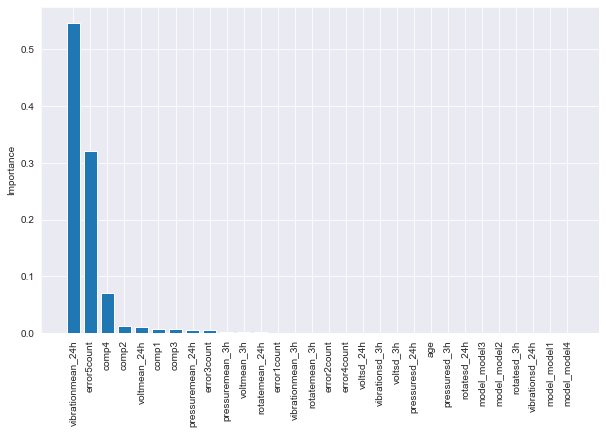

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
labels, importances = zip(*sorted(zip(test_X.columns, models[0].feature_importances_), reverse=True, key=lambda x: x[1]))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')

# Evaluation
In predictive maintenance, machine failures are usually rare occurrences in the lifetime of the assets compared to normal operation. This causes an imbalance in the label distribution which usually causes poor performance as algorithms tend to classify majority class examples better at the expense of minority class examples as the total misclassification error is much improved when majority class is labeled correctly. This causes low recall rates although accuracy can be high and becomes a larger problem when the cost of false alarms to the business is very high. To help with this problem, sampling techniques such as oversampling of the minority examples are usually used along with more sophisticated techniques which are not covered in this notebook.

Text(0, 0.5, &#39;Count&#39;)

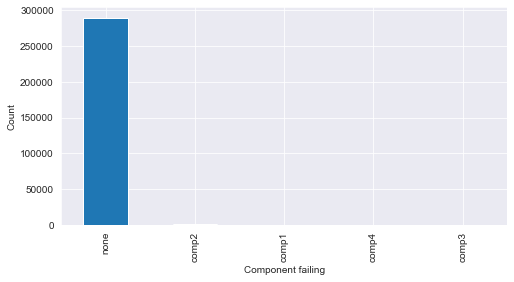

In [26]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
labeled_features['failure'].value_counts().plot(kind='bar')
plt.xlabel('Component failing')
plt.ylabel('Count')

Also, due to the class imbalance problem, it is important to look at evaluation metrics other than accuracy alone and compare those metrics to the baseline metrics which are computed when random chance is used to make predictions rather than a machine learning model. The comparison will bring out the value and benefits of using a machine learning model better.

In the following, we use an evaluation function that computes many important evaluation metrics along with baseline metrics for classification problems. For a detailed explanation of the metrics, please refer to the scikit-learn documentation and a companion blog post (with examples in R, not Python),

In [27]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
    print(cm)
    
    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(['accuracy', 'precision', 'recall', 'F1'])
    
    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(['macro precision', 'macro recall', 'macro F1'])
    
    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis = 1)
    cm_col_sums = cm.sum(axis = 0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis = 1)
    
    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0,0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(['average accuracy',
                          'micro-averaged precision/recall/F1'])
    
    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist; mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist; mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist;
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(['majority class accuracy', 'majority class recall',
                          'majority class precision', 'majority class F1'])
        
    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(['expected accuracy', 'kappa'])
    

    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(['random guess accuracy', 'random guess precision',
                          'random guess recall', 'random guess F1'])
    
    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist**2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(['random weighted guess accuracy',
                          'random weighted guess precision',
                          'random weighted guess recall',
                          'random weighted guess F1'])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels
                  
    return output_df

In [29]:
import numpy as np

evaluation_results = []
for i, test_result in enumerate(test_results):
    print('\nSplit %d:' % (i+1))
    evaluation_result = Evaluate(actual = test_result['failure'],
                                 predicted = test_result['predicted_failure'],
                                 labels = ['none', 'comp1', 'comp2', 'comp3', 'comp4'])
    evaluation_results.append(evaluation_result)
evaluation_results[0]  # show full results for first split only


Split 1:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[    1   164   846 95864     1]
 [    1    38     4     6     2]
 [    0     1    85     4     0]
 [    0     0     2    37     1]
 [    3     0     0    54     0]]


,none,comp1,comp2,comp3,comp4
accuracy,0.001658,0.001658,0.001658,0.001658,0.001658
precision,0.200000,0.187192,0.090715,0.000386,0.000000
recall,0.000010,0.745098,0.944444,0.925000,0.000000
F1,0.000021,0.299213,0.165531,0.000771,NaN
macro precision,0.095659,0.095659,0.095659,0.095659,0.095659
macro recall,0.522911,0.522911,0.522911,0.522911,0.522911
macro F1,NaN,NaN,NaN,NaN,NaN
average accuracy,0.600663,0.600663,0.600663,0.600663,0.600663
micro-averaged precision/recall/F1,0.001658,0.001658,0.001658,0.001658,0.001658
majority class accuracy,0.997549,0.000000,0.000000,0.000000,0.000000


In [ ]:
#In predictive maintenance, we are often most concerned with how many of the actual failures were predicted by the model, i.e. the model's recall. (Recall becomes more important as the consequences of false negatives -- true failures that the model did not predict -- exceed the consequences of false positives, viz. false prediction of impending failure.) Below, we compare the recall rates for each failure type for the three models. The recall rates for all components as well as no failure are all above 90% meaning the model was able to capture above 90% of the failures correctly.


In [30]:
recall_df = pd.DataFrame([evaluation_results[0].loc['recall'].values,
                          evaluation_results[1].loc['recall'].values,
                          evaluation_results[2].loc['recall'].values],
                         columns = ['none', 'comp1', 'comp2', 'comp3', 'comp4'],
                         index = ['recall for first split',
                                  'recall for second split',
                                  'recall for third split'])
recall_df

IndexError: list index out of range